In [ ]:
# Import libraries for data manipulation, visualization, and machine learning
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import pickle
import streamlit as st


In [ ]:
# Load your dataset
df = pd.read_csv('/Copper_Set.xlsx - Result 1.csv')

# Display the first few rows of the dataset
df.head()


<ipython-input-2-d0ca78359082>:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Copper_Set.xlsx - Result 1.csv')


,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,20210401.0,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,20210701.0,854.00
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,20210401.0,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,0000000000000000000000000000000000104991,1668701718,20210401.0,1047.00
2,E140FF1B-2407-4C02-A0DD-780A093B1158,20210401.0,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,S0380700,628377,20210101.0,644.33
3,F8D507A0-9C62-4EFE-831E-33E1DA53BB50,20210401.0,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,DX51D+ZM310MAO 2.3X1317,1668701718,20210101.0,768.00
4,4E1C4E78-152B-430A-8094-ADD889C9D0AD,20210401.0,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,2_S275JR+AR-CL1,640665,20210301.0,577.00


In [ ]:
# Impute missing values
# Convert 'quantity tons' to numeric, handling errors
df['quantity tons'] = pd.to_numeric(df['quantity tons'], errors='coerce')

imputer = SimpleImputer(strategy='mean')  # For numerical columns
df['quantity tons'] = imputer.fit_transform(df[['quantity tons']])
df['thickness'] = imputer.fit_transform(df[['thickness']])
df['width'] = imputer.fit_transform(df[['width']])

# For categorical columns
imputer_cat = SimpleImputer(strategy='most_frequent')  # For categorical columns
# Reshape the output of fit_transform to be 1-dimensional
df['status'] = imputer_cat.fit_transform(df[['status']]).ravel()

In [ ]:
# Log transform for skewed data
df['selling_price'] = np.log1p(df['selling_price'])


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
# Using IQR to detect outliers
Q1 = df['selling_price'].quantile(0.25)
Q3 = df['selling_price'].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = (df['selling_price'] < (Q1 - 1.5 * IQR)) | (df['selling_price'] > (Q3 + 1.5 * IQR))
df = df[~outlier_condition]


In [ ]:
print(df.columns)

Index(['id', 'item_date', 'quantity tons', 'customer', 'country', 'status',
       'item type', 'application', 'thickness', 'width', 'material_ref',
       'product_ref', 'delivery date', 'selling_price'],
      dtype='object')


In [ ]:
# Encode categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(df[['customer', 'country', 'status', 'item type', 'application']])
df_encoded = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['customer', 'country', 'status', 'item type', 'application']))

# Concatenate the encoded columns with the original data
df = pd.concat([df, df_encoded], axis=1)


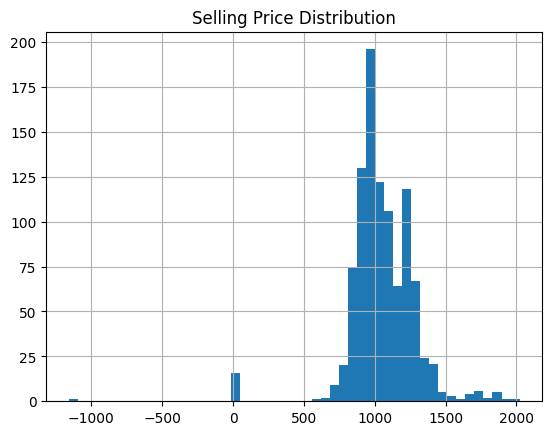

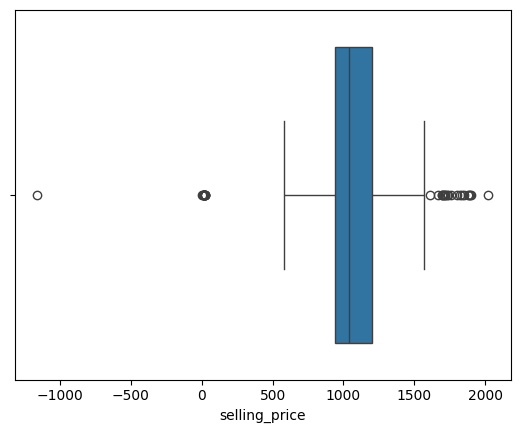

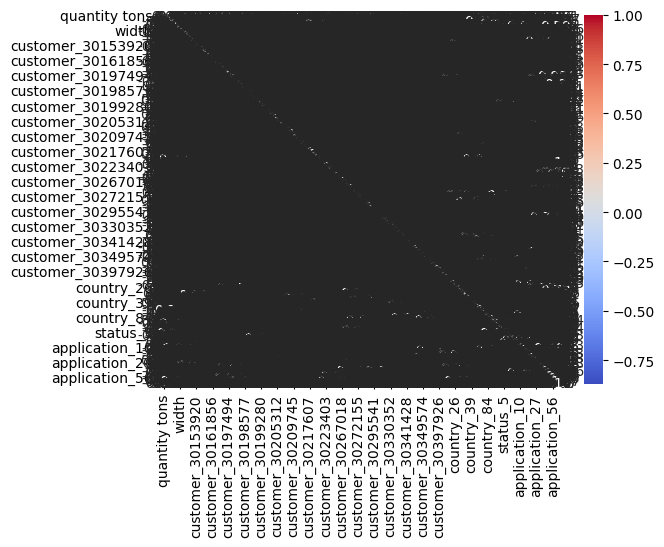

In [ ]:
# Skewness
df['selling_price'].hist(bins=50)
plt.title('Selling Price Distribution')
plt.show()

# Boxplot for outliers
sns.boxplot(x=df['selling_price'])
plt.show()

# Correlation Heatmap: Exclude non-numeric columns
numeric_df = df.select_dtypes(include=[np.number])  # Only select numeric columns
corr = numeric_df.corr()

# Plotting correlation heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()


In [ ]:
# Drop unnecessary columns that are still present in the DataFrame
columns_to_drop = ['id', 'item_date', 'material_ref', 'product_ref', 'delivery date']
# Check which columns to drop are actually in the DataFrame
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
# Drop columns if any
if columns_to_drop:
    df = df.drop(columns=columns_to_drop, axis=1)

# Select only numeric features for scaling
numeric_features = df.drop('selling_price', axis=1).select_dtypes(include=np.number).columns

# Feature scaling
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numeric_features]) # Scale only numeric features

In [ ]:
# Splitting data into training and test sets
X = df_scaled
y = df['selling_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Regression model
model_reg = RandomForestRegressor()
model_reg.fit(X_train, y_train)

# Model evaluation
y_pred_reg = model_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred_reg)
print("Mean Squared Error: ", mse)


Mean Squared Error:  7239.792978431598


In [ ]:
# Classification model
y_class = df['status'].apply(lambda x: 1 if x == 'WON' else 0)  # Convert WON/LOST to binary
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Classification model
model_class = RandomForestClassifier()
model_class.fit(X_train_class, y_train_class)

# Model evaluation
y_pred_class = model_class.predict(X_test_class)
accuracy = accuracy_score(y_test_class, y_pred_class)
print("Accuracy: ", accuracy)


Accuracy:  1.0


In [ ]:
# Save the models
pickle.dump(model_reg, open('model_reg.pkl', 'wb'))
pickle.dump(model_class, open('model_class.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))
pickle.dump(encoder, open('encoder.pkl', 'wb'))


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Print the classification report
print(classification_report(y_test_class, y_pred_class))

# Confusion matrix to visualize the predictions
print(confusion_matrix(y_test_class, y_pred_class))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

[[200]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [ ]:
# Streamlit app for prediction
st.title('Copper Industry Model')

# Inputs for regression
quantity_tons = st.number_input('Quantity (tons)', min_value=0.0)
thickness = st.number_input('Thickness')
width = st.number_input('Width')

# Inputs for classification
customer = st.text_input('Customer')
country = st.text_input('Country')
item_type = st.text_input('Item Type')
application = st.text_input('Application')

# Model predictions
if st.button('Predict'):
    # Prepare the input data for prediction
    input_data = np.array([[quantity_tons, thickness, width, customer, country, item_type, application]])

    # Apply the transformations
    input_data_scaled = scaler.transform(input_data)

    # Load the regression model and make predictions
    model_reg = pickle.load(open('model_reg.pkl', 'rb'))
    pred_price = model_reg.predict(input_data_scaled)

    st.write(f'Predicted Selling Price: {np.expm1(pred_price[0])}')  # Reverse log transformation

    # Load the classification model and make predictions
    model_class = pickle.load(open('model_class.pkl', 'rb'))
    pred_status = model_class.predict(input_data_scaled)

    st.write(f'Predicted Status: {"WON" if pred_status[0] == 1 else "LOST"}')


2024-12-16 03:28:03.441 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-16 03:28:03.573 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-12-16 03:28:03.581 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-16 03:28:03.583 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-16 03:28:03.585 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-16 03:28:03.587 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-16 03:28:03.589 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-16 03:28:03.591 Session state does not 

In [ ]:
# Combine all your code into a string
full_code = '''
# Import libraries for data manipulation, visualization, and machine learning
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import pickle
import streamlit as st

# Load your dataset
df = pd.read_csv('/Copper_Set.xlsx - Result 1.csv')

# Display the first few rows of the dataset
df.head()

# Impute missing values
# Convert 'quantity tons' to numeric, handling errors
df['quantity tons'] = pd.to_numeric(df['quantity tons'], errors='coerce')

imputer = SimpleImputer(strategy='mean')  # For numerical columns
df['quantity tons'] = imputer.fit_transform(df[['quantity tons']])
df['thickness'] = imputer.fit_transform(df[['thickness']])
df['width'] = imputer.fit_transform(df[['width']])

# For categorical columns
imputer_cat = SimpleImputer(strategy='most_frequent')  # For categorical columns
# Reshape the output of fit_transform to be 1-dimensional
df['status'] = imputer_cat.fit_transform(df[['status']]).ravel()

# Log transform for skewed data
df['selling_price'] = np.log1p(df['selling_price'])

# Using IQR to detect outliers
Q1 = df['selling_price'].quantile(0.25)
Q3 = df['selling_price'].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = (df['selling_price'] < (Q1 - 1.5 * IQR)) | (df['selling_price'] > (Q3 + 1.5 * IQR))
df = df[~outlier_condition]

print(df.columns)

# Encode categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(df[['customer', 'country', 'status', 'item type', 'application']])
df_encoded = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['customer', 'country', 'status', 'item type', 'application']))

# Concatenate the encoded columns with the original data
df = pd.concat([df, df_encoded], axis=1)

# Skewness
df['selling_price'].hist(bins=50)
plt.title('Selling Price Distribution')
plt.show()

# Boxplot for outliers
sns.boxplot(x=df['selling_price'])
plt.show()

# Correlation Heatmap: Exclude non-numeric columns
numeric_df = df.select_dtypes(include=[np.number])  # Only select numeric columns
corr = numeric_df.corr()

# Plotting correlation heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

# Drop unnecessary columns that are still present in the DataFrame
columns_to_drop = ['id', 'item_date', 'material_ref', 'product_ref', 'delivery date']
# Check which columns to drop are actually in the DataFrame
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
# Drop columns if any
if columns_to_drop:
    df = df.drop(columns=columns_to_drop, axis=1)

# Select only numeric features for scaling
numeric_features = df.drop('selling_price', axis=1).select_dtypes(include=np.number).columns

# Feature scaling
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[numeric_features]) # Scale only numeric features

# Splitting data into training and test sets
X = df_scaled
y = df['selling_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Regression model
model_reg = RandomForestRegressor()
model_reg.fit(X_train, y_train)

# Model evaluation
y_pred_reg = model_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred_reg)
print("Mean Squared Error: ", mse)

# Classification model
y_class = df['status'].apply(lambda x: 1 if x == 'WON' else 0)  # Convert WON/LOST to binary
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Classification model
model_class = RandomForestClassifier()
model_class.fit(X_train_class, y_train_class)

# Model evaluation
y_pred_class = model_class.predict(X_test_class)
accuracy = accuracy_score(y_test_class, y_pred_class)
print("Accuracy: ", accuracy)

# Save the models
pickle.dump(model_reg, open('model_reg.pkl', 'wb'))
pickle.dump(model_class, open('model_class.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))
pickle.dump(encoder, open('encoder.pkl', 'wb'))

from sklearn.metrics import classification_report, confusion_matrix

# Print the classification report
print(classification_report(y_test_class, y_pred_class))

# Confusion matrix to visualize the predictions
print(confusion_matrix(y_test_class, y_pred_class))

# Streamlit app for prediction
st.title('Copper Industry Model')

# Inputs for regression
quantity_tons = st.number_input('Quantity (tons)', min_value=0.0)
thickness = st.number_input('Thickness')
width = st.number_input('Width')

# Inputs for classification
customer = st.text_input('Customer')
country = st.text_input('Country')
item_type = st.text_input('Item Type')
application = st.text_input('Application')

# Model predictions
if st.button('Predict'):
    # Prepare the input data for prediction
    input_data = np.array([[quantity_tons, thickness, width, customer, country, item_type, application]])

    # Apply the transformations
    input_data_scaled = scaler.transform(input_data)

    # Load the regression model and make predictions
    model_reg = pickle.load(open('model_reg.pkl', 'rb'))
    pred_price = model_reg.predict(input_data_scaled)

    st.write(f'Predicted Selling Price: {np.expm1(pred_price[0])}')  # Reverse log transformation

    # Load the classification model and make predictions
    model_class = pickle.load(open('model_class.pkl', 'rb'))
    pred_status = model_class.predict(input_data_scaled)

    st.write(f'Predicted Status: {"WON" if pred_status[0] == 1 else "LOST"}')
'''

# Save the code to a Python file (app.py)
with open('/content/copper_model_app.py', 'w') as f:
    f.write(full_code)

print("Full code saved to 'copper_model_app.py'")


Full code saved to 'copper_model_app.py'


In [ ]:
!pip install streamlit pyngrok



In [ ]:
from pyngrok import ngrok
import os

# Authenticate ngrok - Ensure the authtoken is correct and enclosed in quotes
!ngrok authtoken "2qGH8tc3gftImADGsqH6lQBz19U_8DFcqnFsvNcJwEtfjmbQ"

# Set the path to your Streamlit app
streamlit_app_path = '/content/copper_model_app.py'

# Open a tunnel on port 8501 for the Streamlit app
# Updated to specify the port within the 'config' dictionary and 'addr' key
tunnel = ngrok.connect(addr=8501, proto="http", bind_tls=True)
public_url = tunnel.public_url

# Run Streamlit app in the background
os.system(f"streamlit run {streamlit_app_path} &")

print(f"Streamlit app is running at {public_url}")

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
Streamlit app is running at https://af2b-34-16-147-4.ngrok-free.app
